# Graph Types and Structures Lab --> Project 3 Workspace

In [5]:
import neo4j
import pandas as pd
from IPython.display import display

In [6]:
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

## Remember the Basics

- Calmly, Orderly, Systematically, Logically... reduce the Search Space
- Expect and make peace with frustration and confusion. Both demonstrate stretching ourselves out of our comfort zone, learning at our maximum potential, not limiting ourselves to what is easy to learn. 

#### Nodes (vertices) can have: labels for classification and properties (attributes as key / value pairs)

#### Relationships (edges) can have: type, direction, and properties (attributes as key / value pairs); 

Additional Reading: 
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

#### Jupyter Hotkeys for VSC

Creating Cells

1. Create a Code Cell After the Current Position:
• Mac: Option + Enter
	This hotkey will create a new code cell directly below the currently selected cell and move the cursor to the new cell.

2. Create a Markdown Cell After the Current Position:
• Mac: Cmd + Shift + Option + M
	Alternatively, you can convert an existing code cell to a markdown cell using:
	•Mac: M (when the cell is in command mode)

Running Cells

1. Run All Cells Above a Certain Point:
	There isn’t a direct hotkey to run all cells above the current point. However, you can accomplish this by:
	• Command Palette: Cmd + Shift + P (Mac) to open the Command Palette, then type “Run Above” and select “Run Above”.

#### Web server interface at https://xxxx:7473

**Username: neo4j**

**Password: ucb_mids_w205**

The above web server allows and interactive GUI which can output graphs visually in addition to table like output.  The nodes in the graphs can be moved around with the mouse to make the graphs more readable.


#### Basics:

```:server connect``` - connect to the server, username is "neo4j", password is "ucb_mids_w205"

```:server status``` - shows that username and server you are logged into

```:clear``` - clears off old cells

```show databases``` - note that community edition only has 1 application database that we can use neo4j, we cannot create now use other databases, we have to wipe out neo4j database for each new graph

#### Cypher as the query language: 
- analogous to SQL for a relational database; Cypher is open source and like SQL is used for multiple database, Cypher can be used for other graph databases


```()``` node


```[]``` relationships


```-> <-``` directions, every relationship must have 1 and only 1 direction


```(p:Person)``` p is a variable, Person is a node label


```(:Person)``` no variable, Person is a node label


```(p:Person {name: 'John', birth_year: 1970})``` name is a property of the node with value 'John', and birth_year is a property with value 1970


```(p1:Person {name: 'John'})-[r:IS_FRIEND_OF]->(p2:Person {name: 'Mary'})``` r is a variable, IS_FRIEND_OF is a relationship type


```(p1:Person {name: 'John'})-[:IS_FRIEND_OF {since: 1983}]->(p2:Person {name: 'Mary'})``` since is a property of the relationship

```match``` matches a pattern of nodes and/or relationships

```return``` which properties of nodes and/or relationships to return

```order by``` sorting just like SQL

```limit```  limiting the rows returned just like SQL

```collect``` a form of a pivot to turn rows into a list

```unwind``` a form of an unpivot to turn a list into rows

```create``` creates nodes and/or relationships

```delete``` deletes nodes and/or relationships

### Connect, login, create driver, create session; with community edition, we can only use 1 database, the "neo4j" database

In [7]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://<EXTERNAL_IP>:7687", auth=("neo4j", "ucb_mids_w205"))


In [8]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

Local -> Cloud access, comment out prior to submitting

In [9]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

In [10]:
session = driver.session(database="neo4j")

# Function Definitions

### Visualize Graph

In [11]:
# PRODUCTION VERSION

# !pip install networkx
# !pip install py2neo
# !pip install scipy
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the graph using networkx
def visualize_graph(title="Neo4j Graph Visualization"):
    # Connect to the Neo4j database
    graph = Graph("bolt://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

    # Define a query to get nodes and relationships
    query = """
    MATCH (n)-[r]->(m)
    RETURN n.name AS from, type(r) AS type, m.name AS to
    """

    # Run the query
    results = graph.run(query)

    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add nodes and edges to the NetworkX graph
    for record in results:
        G.add_edge(record["from"], record["to"], label=record["type"])

    # Choose a layout algorithm
    # pos = nx.spring_layout(G, k=0.5)  # k controls the distance between nodes - CHAOS
    # pos = nx.circular_layout(G) #  DIFFICULT TO WEIGHT
    pos = nx.shell_layout(G) # BETTER
    # pos = nx.kamada_kawai_layout(G, weight=None) # 

    # Draw the nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=45)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="normal")

    # Draw the edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Display the graph
    plt.title(title)
    plt.show()

### my_neo4j_wipe_out_database() 
- since community edition can only have 1 database "neo4j", this function will wipe out all the nodes and relationships

In [12]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

### my_neo4j_run_query_pandas() 
will run a Cypher query and put the results in a Pandas dataframe; easy to see how you can use Python to manipulate the returned data

In [13]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

### my_neo4j_nodes_relationships() 
- will print the nodes (assumes a name property) and relationships

In [14]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

### Testing Workspace

#### Simple graph of several people and who is a friend of whom

In [15]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John', born: 1970}),
  (mary:Person {name: 'Mary', born: 1972}),
  (mark:Person {name: 'Mark', born: 1968}),
  (linda:Person {name: 'Linda', born: 1967}),
  (larry:Person {name: 'Larry', born: 1965}),
  (john)-[:IS_FRIEND_OF {since: 1983}]->(mary),
  (john)-[:IS_FRIEND_OF {since: 1984}]->(mark),
  (john)-[:IS_FRIEND_OF {since: 1982}]->(linda),
  (mary)-[:IS_FRIEND_OF {since: 1981}]->(larry),
  (mark)-[:IS_FRIEND_OF {since: 1983}]->(larry),
  (linda)-[:IS_FRIEND_OF {since: 1984}]->(larry)

"""

session.run(query)

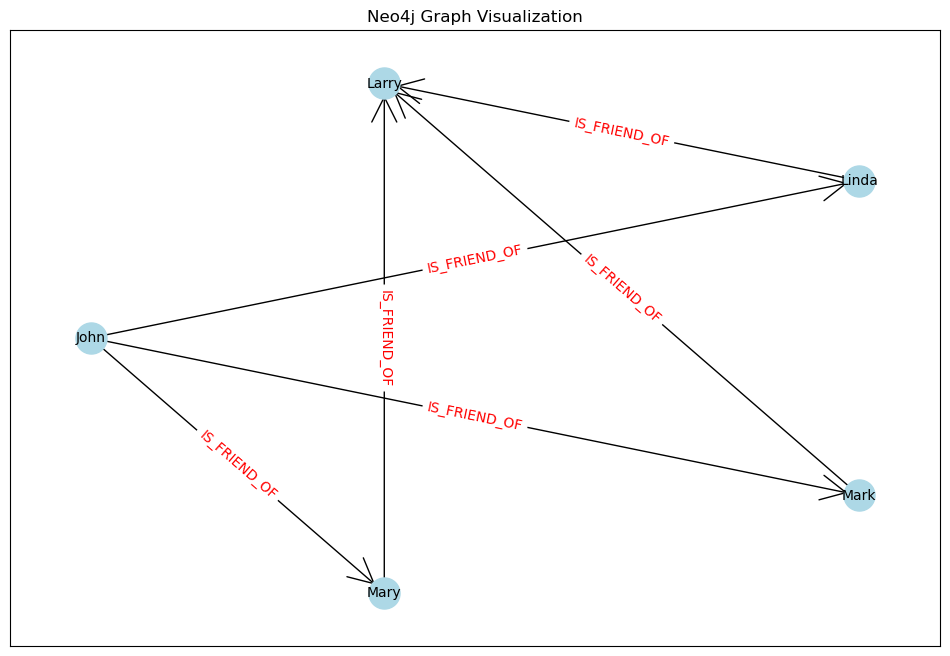

In [16]:
visualize_graph()

In [17]:
print(my_neo4j_nodes_relationships())
# my_neo4j_wipe_out_database()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,John,[Person]
1,Larry,[Person]
2,Linda,[Person]
3,Mark,[Person]
4,Mary,[Person]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,John,[Person],IS_FRIEND_OF,Linda,[Person]
1,John,[Person],IS_FRIEND_OF,Mark,[Person]
2,John,[Person],IS_FRIEND_OF,Mary,[Person]
3,Linda,[Person],IS_FRIEND_OF,Larry,[Person]
4,Mark,[Person],IS_FRIEND_OF,Larry,[Person]
5,Mary,[Person],IS_FRIEND_OF,Larry,[Person]


-------------------------
  Density: 0.6
-------------------------
None


#### In the Neo4j GUI, run the following query with graph output and rearrange the nodes with your mouse if necessary:

```match (n) return n```

## Random Network - flat, no patterns, all nodes have the same probability of being attached to each other

In [18]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (a)-[:IS_CONNECTED_TO]->(e),
  (a)-[:IS_CONNECTED_TO]->(g),
  (b)-[:IS_CONNECTED_TO]->(g),
  (c)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(h),
  (e)-[:IS_CONNECTED_TO]->(h),
  (f)-[:IS_CONNECTED_TO]->(g),
  (f)-[:IS_CONNECTED_TO]->(i)
  
"""

session.run(query)

In [19]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]
6,G,[Generic]
7,H,[Generic]
8,I,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,E,[Generic]
1,A,[Generic],IS_CONNECTED_TO,G,[Generic]
2,B,[Generic],IS_CONNECTED_TO,G,[Generic]
3,C,[Generic],IS_CONNECTED_TO,F,[Generic]
4,C,[Generic],IS_CONNECTED_TO,G,[Generic]
5,D,[Generic],IS_CONNECTED_TO,H,[Generic]
6,E,[Generic],IS_CONNECTED_TO,H,[Generic]
7,F,[Generic],IS_CONNECTED_TO,G,[Generic]
8,F,[Generic],IS_CONNECTED_TO,I,[Generic]


-------------------------
  Density: 0.2
-------------------------


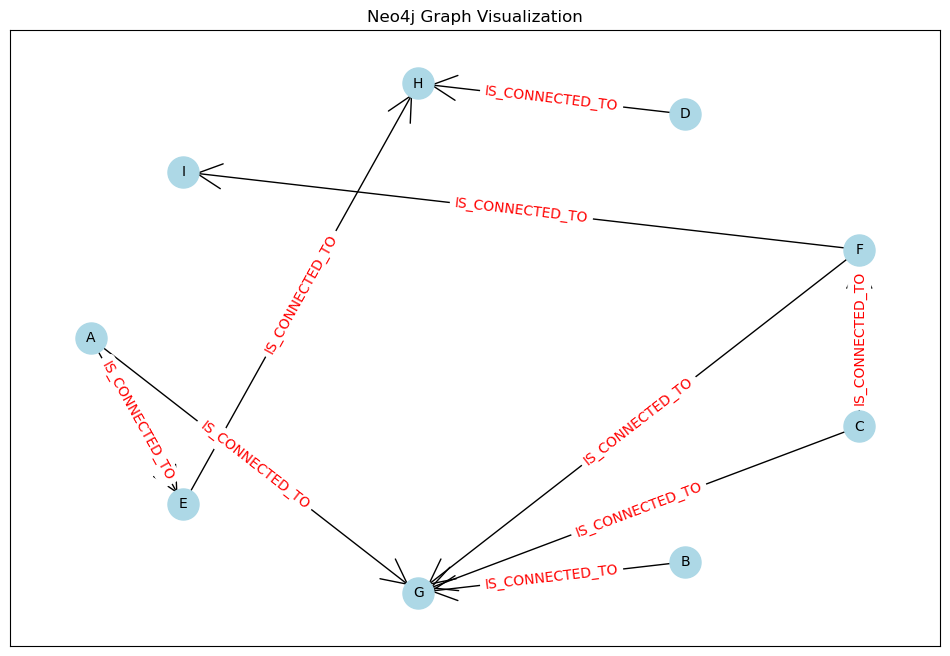

In [20]:
# Visualize the Random Network
visualize_graph()

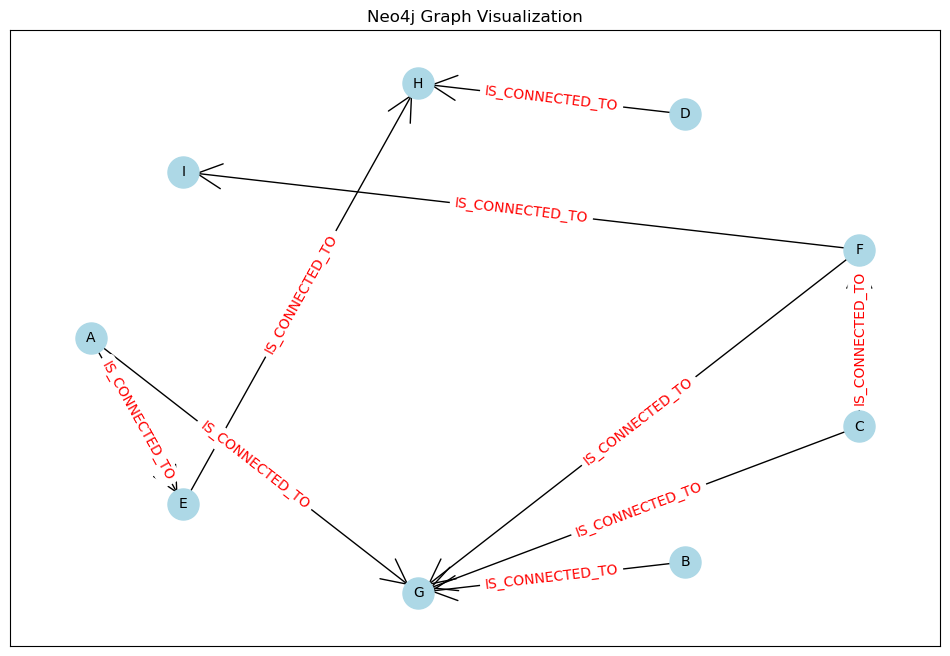

In [21]:
# Visualize the Small World Clustering Example (now removed)
visualize_graph()

## P0: Set B: Scale-Free Network - hub and spoke in multiple scales, power-law distribution (change in one quantity results in relatively proportional change in another quantity

In [22]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (j:Generic {name: 'J'}),
  (k:Generic {name: 'K'}),
  (l:Generic {name: 'L'}),
  (m:Generic {name: 'M'}),
  (n:Generic {name: 'N'}),
  (o:Generic {name: 'O'}),
  (p:Generic {name: 'P'}),
  (q:Generic {name: 'Q'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (b)-[:IS_CONNECTED_TO]->(n),
  (b)-[:IS_CONNECTED_TO]->(o),
  (b)-[:IS_CONNECTED_TO]->(p),
  (b)-[:IS_CONNECTED_TO]->(q),
  (c)-[:IS_CONNECTED_TO]->(j),
  (c)-[:IS_CONNECTED_TO]->(k),
  (c)-[:IS_CONNECTED_TO]->(l),
  (c)-[:IS_CONNECTED_TO]->(m),
  (d)-[:IS_CONNECTED_TO]->(e),
  (d)-[:IS_CONNECTED_TO]->(f),
  (d)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(h),
  (d)-[:IS_CONNECTED_TO]->(i)
  
"""

session.run(query)

In [23]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]
6,G,[Generic]
7,H,[Generic]
8,I,[Generic]
9,J,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,B,[Generic]
1,A,[Generic],IS_CONNECTED_TO,C,[Generic]
2,A,[Generic],IS_CONNECTED_TO,D,[Generic]
3,B,[Generic],IS_CONNECTED_TO,N,[Generic]
4,B,[Generic],IS_CONNECTED_TO,O,[Generic]
5,B,[Generic],IS_CONNECTED_TO,P,[Generic]
6,B,[Generic],IS_CONNECTED_TO,Q,[Generic]
7,C,[Generic],IS_CONNECTED_TO,J,[Generic]
8,C,[Generic],IS_CONNECTED_TO,K,[Generic]
9,C,[Generic],IS_CONNECTED_TO,L,[Generic]


-------------------------
  Density: 0.1
-------------------------


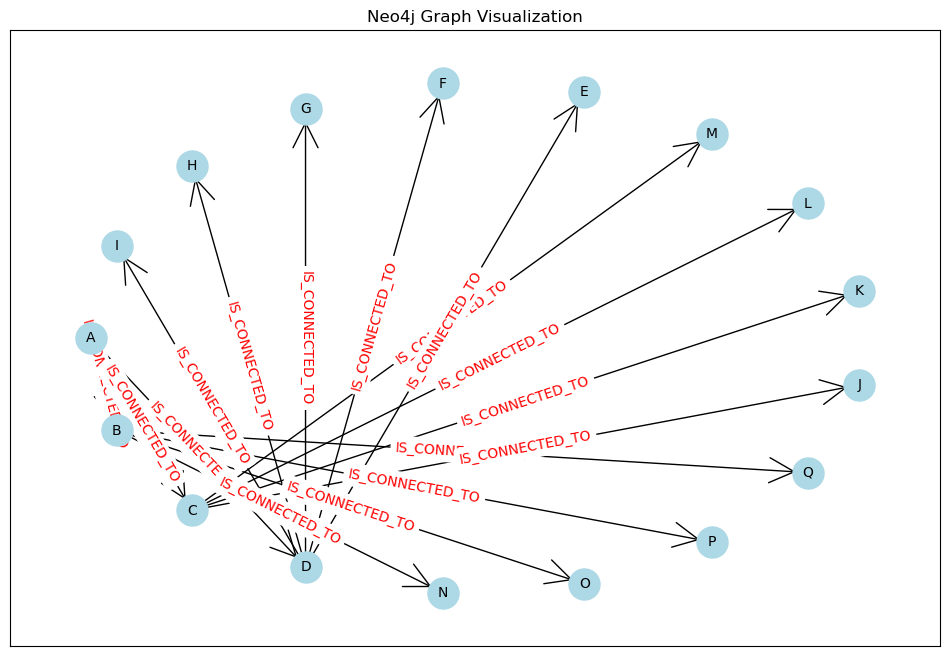

In [24]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Connected, Disconnected, Weighted, Unweighted

## Connected - path between any 2 nodes (regardless of the distance), all graphs we have seen up until now have been connected

## P0 Sets_A,B,C_initialization_procedure: Disconnected - some nodes may not be connected to other nodes, "islands" - group of connected nodes disconnected from the main graph

In [25]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (h:Generic {name: 'H'}),
  (i:Generic {name: 'I'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (d)-[:IS_CONNECTED_TO]->(e),
  (f)-[:IS_CONNECTED_TO]->(g),
  (f)-[:IS_CONNECTED_TO]->(h),
  (f)-[:IS_CONNECTED_TO]->(i),
  (g)-[:IS_CONNECTED_TO]->(h),
  (h)-[:IS_CONNECTED_TO]->(i)

"""

session.run(query)

In [26]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]
6,G,[Generic]
7,H,[Generic]
8,I,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,B,[Generic]
1,A,[Generic],IS_CONNECTED_TO,C,[Generic]
2,D,[Generic],IS_CONNECTED_TO,E,[Generic]
3,F,[Generic],IS_CONNECTED_TO,G,[Generic]
4,F,[Generic],IS_CONNECTED_TO,H,[Generic]
5,F,[Generic],IS_CONNECTED_TO,I,[Generic]
6,G,[Generic],IS_CONNECTED_TO,H,[Generic]
7,H,[Generic],IS_CONNECTED_TO,I,[Generic]


-------------------------
  Density: 0.2
-------------------------


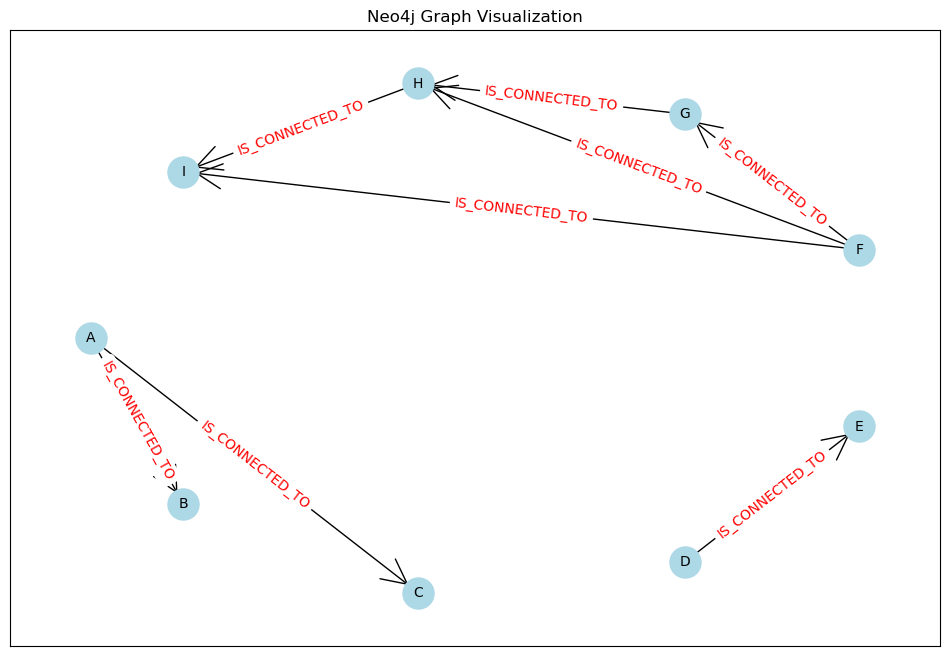

In [27]:
# Visualize the Random Network
visualize_graph()

## Unweighted - no numeric value placed on the relationships, all the graphs we have seen up until now have been unweighted, some algorithms require weights, some algorithms do not consider weights, some algoritms default unweighted to a weight of 1 

## P2: Bi/K-Partite AND/OR Model Graph: Weighted - numeric values placed on a relationship

In [28]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A', weight: 5}),
  (b:Generic {name: 'B', weight: 7}),
  (c:Generic {name: 'C', weight: 8}),
  (d:Generic {name: 'D', weight: 3}),
  (e:Generic {name: 'E', weight: 4}),
  (a)-[:IS_CONNECTED_TO {weight: 110}]->(b),
  (a)-[:IS_CONNECTED_TO {weight: 120}]->(c),
  (b)-[:IS_CONNECTED_TO {weight: 123}]->(c),
  (c)-[:IS_CONNECTED_TO {weight: 127}]->(d),
  (d)-[:IS_CONNECTED_TO {weight: 117}]->(e)
  
"""

session.run(query)

In [29]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,B,[Generic]
1,A,[Generic],IS_CONNECTED_TO,C,[Generic]
2,B,[Generic],IS_CONNECTED_TO,C,[Generic]
3,C,[Generic],IS_CONNECTED_TO,D,[Generic]
4,D,[Generic],IS_CONNECTED_TO,E,[Generic]


-------------------------
  Density: 0.5
-------------------------


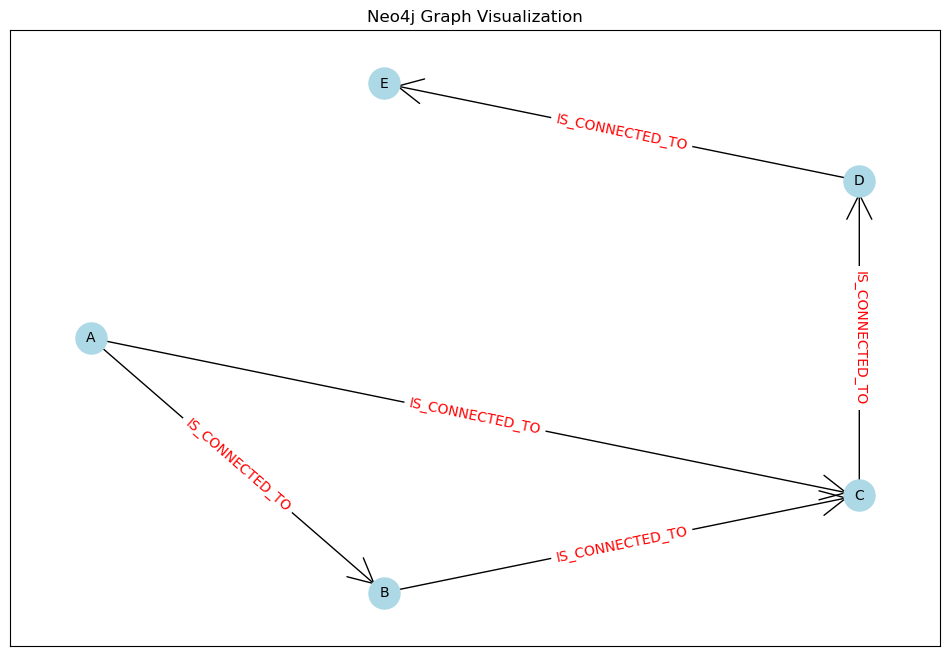

In [30]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Cyclic, Acyclic, Trees

## P0_Set_A: Cyclic  - has cycles, path from a node back to itself, some algorithms can get stuck in cycles

In [31]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (a)-[:IS_CONNECTED_TO]->(c),
  (c)-[:IS_CONNECTED_TO]->(d),
  (d)-[:IS_CONNECTED_TO]->(a),
  (d)-[:IS_CONNECTED_TO]->(e),
  (c)-[:IS_CONNECTED_TO]->(b),
  (b)-[:IS_CONNECTED_TO]->(f),
  (f)-[:IS_CONNECTED_TO]->(c)
  
"""

session.run(query)

In [32]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,C,[Generic]
1,B,[Generic],IS_CONNECTED_TO,F,[Generic]
2,C,[Generic],IS_CONNECTED_TO,B,[Generic]
3,C,[Generic],IS_CONNECTED_TO,D,[Generic]
4,D,[Generic],IS_CONNECTED_TO,A,[Generic]
5,D,[Generic],IS_CONNECTED_TO,E,[Generic]
6,F,[Generic],IS_CONNECTED_TO,C,[Generic]


-------------------------
  Density: 0.5
-------------------------


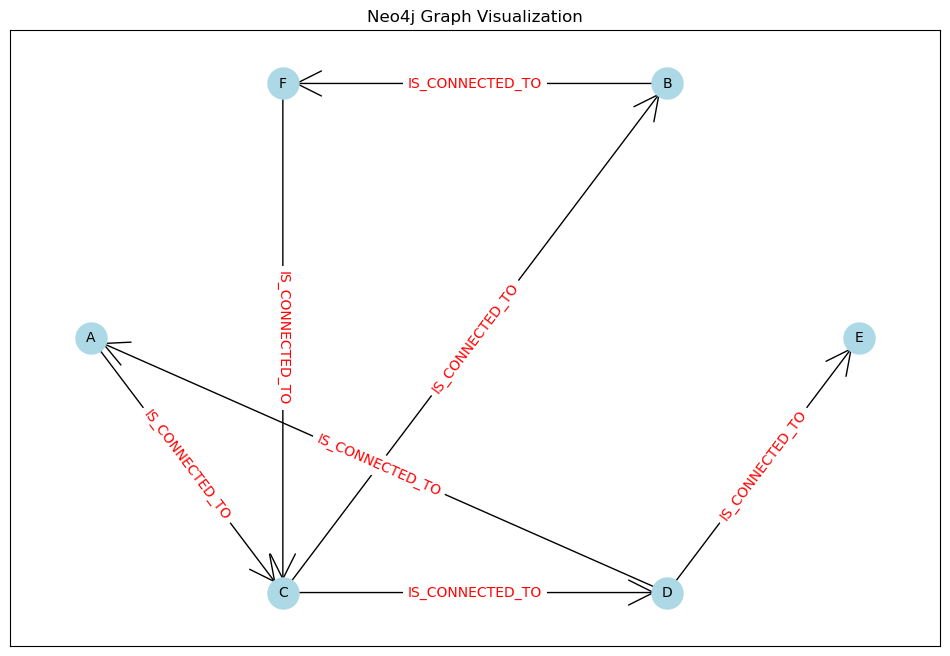

In [33]:
# Visualize the Random Network
visualize_graph()

## P1: Acyclic - no cycles, no node has a path back to itself, a lot of algorithms require acyclic

In [34]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (g:Generic {name: 'G'}),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (a)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(b),
  (c)-[:IS_CONNECTED_TO]->(g),
  (d)-[:IS_CONNECTED_TO]->(e)
  
"""

session.run(query)

In [35]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]
6,G,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,C,[Generic]
1,A,[Generic],IS_CONNECTED_TO,D,[Generic]
2,A,[Generic],IS_CONNECTED_TO,F,[Generic]
3,C,[Generic],IS_CONNECTED_TO,B,[Generic]
4,C,[Generic],IS_CONNECTED_TO,G,[Generic]
5,D,[Generic],IS_CONNECTED_TO,E,[Generic]


-------------------------
  Density: 0.3
-------------------------


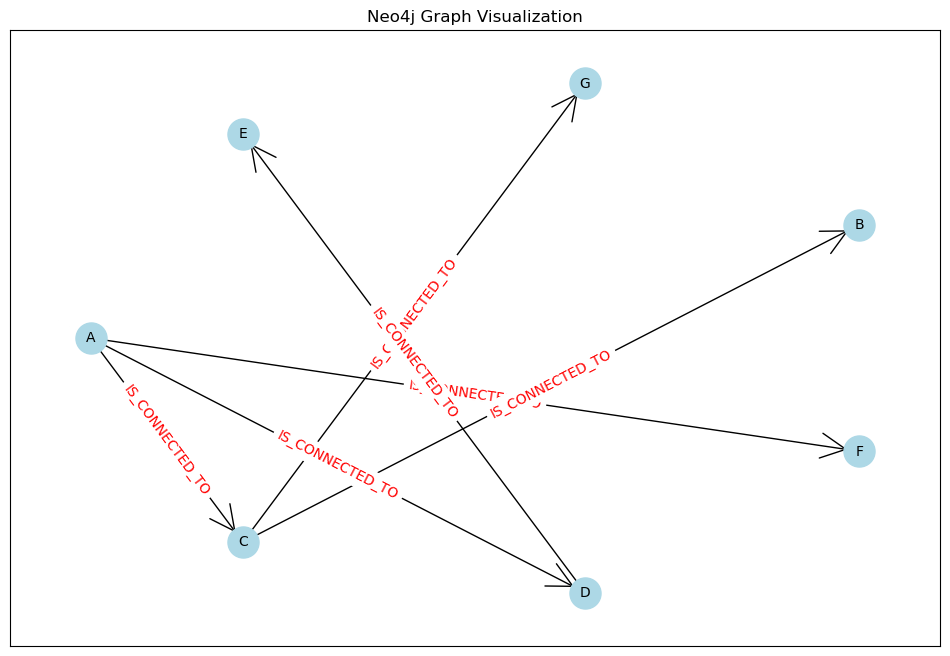

In [36]:
# Visualize the Random Network
visualize_graph()

## P0_Sets_A,B: Trees - acyclic graphs, spanning tree - all nodes in a graph with relationships removed to remove cycles; we will take our cyclic graph example and remove relationships until we have a spanning tree

In [37]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a1:Generic {name: 'A1'}),
  (b1:Generic {name: 'B1'}),
  (c1:Generic {name: 'C1'}),
  (d1:Generic {name: 'D1'}),
  (e1:Generic {name: 'E1'}),
  (f1:Generic {name: 'F1'}),
  (a1)-[:IS_CONNECTED_TO]->(c1),
  (c1)-[:IS_CONNECTED_TO]->(d1),
  (d1)-[:IS_CONNECTED_TO]->(a1),
  (d1)-[:IS_CONNECTED_TO]->(e1),
  (c1)-[:IS_CONNECTED_TO]->(b1),
  (b1)-[:IS_CONNECTED_TO]->(f1),
  (f1)-[:IS_CONNECTED_TO]->(c1),
  (a2:Generic {name: 'A2'}),
  (b2:Generic {name: 'B2'}),
  (c2:Generic {name: 'C2'}),
  (d2:Generic {name: 'D2'}),
  (e2:Generic {name: 'E2'}),
  (f2:Generic {name: 'F2'}),
  (a2)-[:IS_CONNECTED_TO]->(c2),
  (c2)-[:IS_CONNECTED_TO]->(b2),
  (b2)-[:IS_CONNECTED_TO]->(f2),
  (c2)-[:IS_CONNECTED_TO]->(d2),
  (d2)-[:IS_CONNECTED_TO]->(e2)
  
"""

session.run(query)

In [38]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A1,[Generic]
1,A2,[Generic]
2,B1,[Generic]
3,B2,[Generic]
4,C1,[Generic]
5,C2,[Generic]
6,D1,[Generic]
7,D2,[Generic]
8,E1,[Generic]
9,E2,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A1,[Generic],IS_CONNECTED_TO,C1,[Generic]
1,A2,[Generic],IS_CONNECTED_TO,C2,[Generic]
2,B1,[Generic],IS_CONNECTED_TO,F1,[Generic]
3,B2,[Generic],IS_CONNECTED_TO,F2,[Generic]
4,C1,[Generic],IS_CONNECTED_TO,B1,[Generic]
5,C1,[Generic],IS_CONNECTED_TO,D1,[Generic]
6,C2,[Generic],IS_CONNECTED_TO,B2,[Generic]
7,C2,[Generic],IS_CONNECTED_TO,D2,[Generic]
8,D1,[Generic],IS_CONNECTED_TO,A1,[Generic]
9,D1,[Generic],IS_CONNECTED_TO,E1,[Generic]


-------------------------
  Density: 0.2
-------------------------


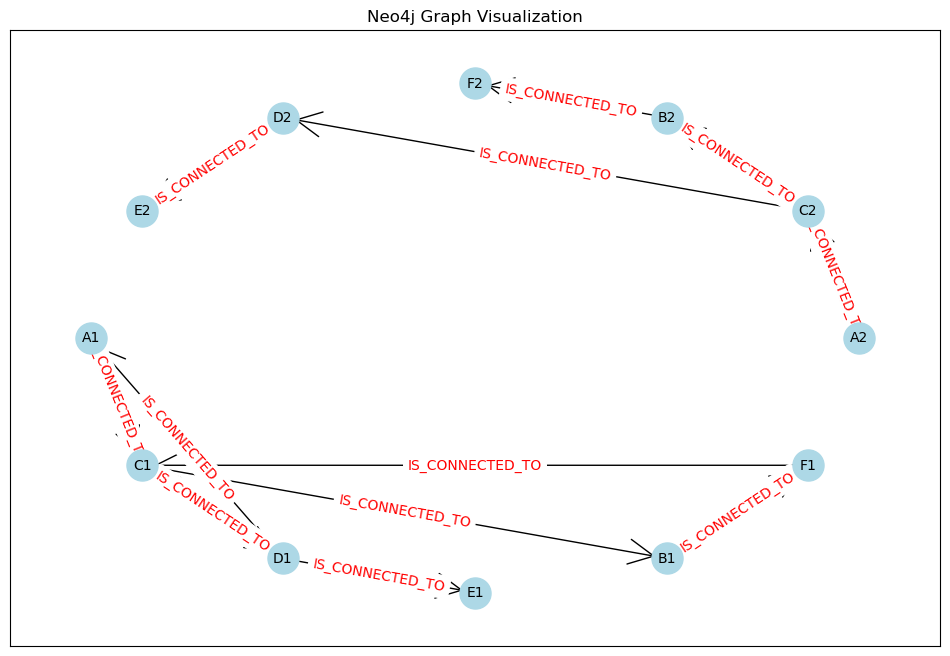

In [39]:
# Visualize the Random Network
visualize_graph()

# Lab: Neo4j - Density Calculations, Sparse Graphs, Dense Graphs

## Density Calculations:

* Maximum Density = (nodes (nodes - 1) ) / 2


* Actual Density = (2 * relationships) / (nodes * (nodes - 1) )

## P2: Dense Graph - high density

P2 - If time, use for Model -> Company Relationship, derived from MongoDB

In [40]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (a:Generic {name: 'A'}),
  (b:Generic {name: 'B'}),
  (c:Generic {name: 'C'}),
  (d:Generic {name: 'D'}),
  (e:Generic {name: 'E'}),
  (f:Generic {name: 'F'}),
  (a)-[:IS_CONNECTED_TO]->(b),
  (a)-[:IS_CONNECTED_TO]->(c),
  (a)-[:IS_CONNECTED_TO]->(d),
  (a)-[:IS_CONNECTED_TO]->(f),
  (b)-[:IS_CONNECTED_TO]->(c),
  (b)-[:IS_CONNECTED_TO]->(d),
  (b)-[:IS_CONNECTED_TO]->(e),
  (b)-[:IS_CONNECTED_TO]->(f),
  (c)-[:IS_CONNECTED_TO]->(d),
  (c)-[:IS_CONNECTED_TO]->(e),
  (c)-[:IS_CONNECTED_TO]->(f),
  (d)-[:IS_CONNECTED_TO]->(e),
  (d)-[:IS_CONNECTED_TO]->(f),
  (e)-[:IS_CONNECTED_TO]->(f)
  
"""

session.run(query)

In [41]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Generic]
1,B,[Generic]
2,C,[Generic]
3,D,[Generic]
4,E,[Generic]
5,F,[Generic]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,A,[Generic],IS_CONNECTED_TO,B,[Generic]
1,A,[Generic],IS_CONNECTED_TO,C,[Generic]
2,A,[Generic],IS_CONNECTED_TO,D,[Generic]
3,A,[Generic],IS_CONNECTED_TO,F,[Generic]
4,B,[Generic],IS_CONNECTED_TO,C,[Generic]
5,B,[Generic],IS_CONNECTED_TO,D,[Generic]
6,B,[Generic],IS_CONNECTED_TO,E,[Generic]
7,B,[Generic],IS_CONNECTED_TO,F,[Generic]
8,C,[Generic],IS_CONNECTED_TO,D,[Generic]
9,C,[Generic],IS_CONNECTED_TO,E,[Generic]


-------------------------
  Density: 0.9
-------------------------


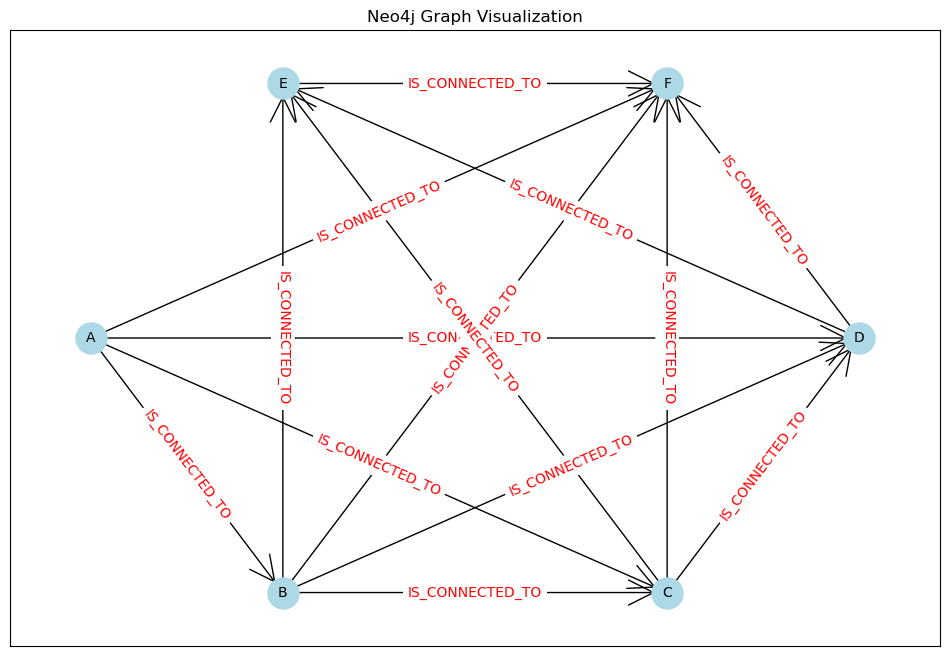

In [42]:
# Visualize the Random Network
visualize_graph()

# P2 Lab: Neo4j - Bipartite, k-Partite Graphs

##### Monopartitie - 1 node label, 1 relationship type, all graphs we have seen so far are monopartitie

## P2 Bipartite - two sets, nodes from one set only connect to nodes in the other set

In [43]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John'}),
  (mary:Person {name: 'Mary'}),
  (linda:Person {name: 'Linda'}),
  (a:Club {name: 'Club A'}),
  (b:Club {name: 'Club B'}),
  (c:Club {name: 'Club C'}),
  (mary)-[:IS_MEMBER_OF]->(a),
  (mary)-[:IS_MEMBER_OF]->(b),
  (mary)-[:IS_MEMBER_OF]->(c),
  (linda)-[:IS_MEMBER_OF]->(a),
  (john)-[:IS_MEMBER_OF]->(b),
  (john)-[:IS_MEMBER_OF]->(c)
  
"""

session.run(query)

In [44]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Club A,[Club]
1,Club B,[Club]
2,Club C,[Club]
3,John,[Person]
4,Linda,[Person]
5,Mary,[Person]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,John,[Person],IS_MEMBER_OF,Club B,[Club]
1,John,[Person],IS_MEMBER_OF,Club C,[Club]
2,Linda,[Person],IS_MEMBER_OF,Club A,[Club]
3,Mary,[Person],IS_MEMBER_OF,Club A,[Club]
4,Mary,[Person],IS_MEMBER_OF,Club B,[Club]
5,Mary,[Person],IS_MEMBER_OF,Club C,[Club]


-------------------------
  Density: 0.4
-------------------------


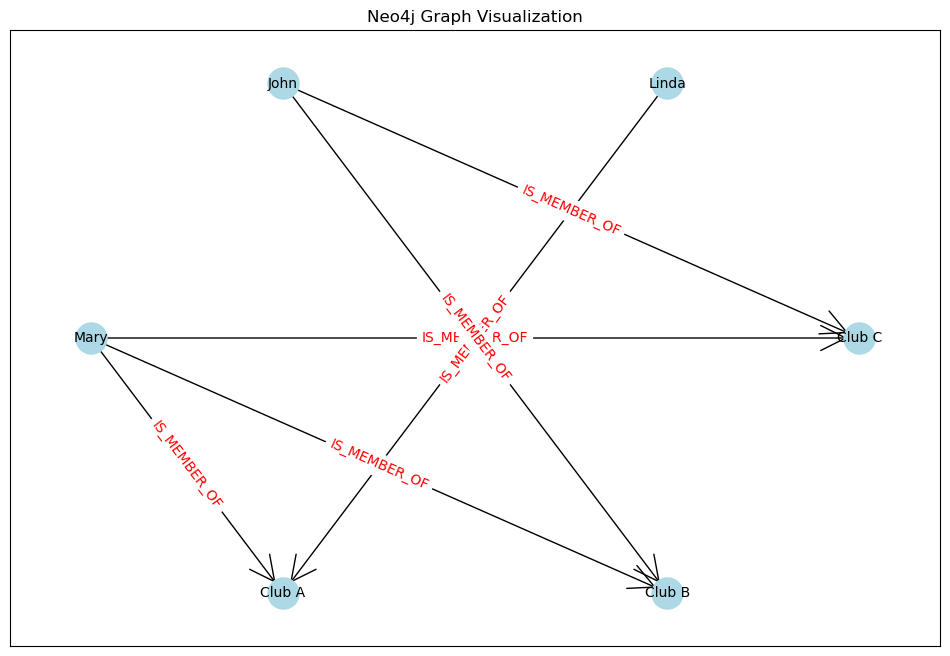

In [45]:
# Visualize the Random Network
visualize_graph()

## k-Partite - k sets, nodes from one set only connect to nodes in another set, most real world graphs have a high k value; in this example k=4: Person, Club, Course, Day

In [46]:
my_neo4j_wipe_out_database()

query = """

CREATE
  (john:Person {name: 'John'}),
  (mary:Person {name: 'Mary'}),
  (linda:Person {name: 'Linda'}),
  (a:Club {name: 'Club A'}),
  (b:Club {name: 'Club B'}),
  (c:Club {name: 'Club C'}),
  (ds:Course {name: 'Data Structures'}),
  (as:Course {name: 'Assembler'}),
  (st:Course {name: 'Statictics'}),
  (lt:Course {name: 'Laplace Transform'}),
  (tu:Day {name: 'Tuesday'}),
  (th:Day {name: 'Thursday'}),
  (mary)-[:IS_MEMBER_OF]->(a),
  (mary)-[:IS_MEMBER_OF]->(b),
  (mary)-[:IS_MEMBER_OF]->(c),
  (linda)-[:IS_MEMBER_OF]->(a),
  (john)-[:IS_MEMBER_OF]->(b),
  (john)-[:IS_MEMBER_OF]->(c),
  (mary)-[:IS_TAKING]->(st),
  (mary)-[:IS_TAKING]->(lt),
  (linda)-[:IS_TAKING]->(ds),
  (linda)-[:IS_TAKING]->(st),
  (linda)-[:IS_TAKING]->(lt),
  (john)-[:IS_TAKING]->(as),
  (ds)-[:TAUGHT_ON]->(tu),
  (st)-[:TAUGHT_ON]->(tu),
  (as)-[:TAUGHT_ON]->(th),
  (lt)-[:TAUGHT_ON]->(th)
  
"""

session.run(query)

In [47]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Assembler,[Course]
1,Club A,[Club]
2,Club B,[Club]
3,Club C,[Club]
4,Data Structures,[Course]
5,John,[Person]
6,Laplace Transform,[Course]
7,Linda,[Person]
8,Mary,[Person]
9,Statictics,[Course]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Assembler,[Course],TAUGHT_ON,Thursday,[Day]
1,Data Structures,[Course],TAUGHT_ON,Tuesday,[Day]
2,John,[Person],IS_TAKING,Assembler,[Course]
3,John,[Person],IS_MEMBER_OF,Club B,[Club]
4,John,[Person],IS_MEMBER_OF,Club C,[Club]
5,Laplace Transform,[Course],TAUGHT_ON,Thursday,[Day]
6,Linda,[Person],IS_MEMBER_OF,Club A,[Club]
7,Linda,[Person],IS_TAKING,Data Structures,[Course]
8,Linda,[Person],IS_TAKING,Laplace Transform,[Course]
9,Linda,[Person],IS_TAKING,Statictics,[Course]


-------------------------
  Density: 0.2
-------------------------


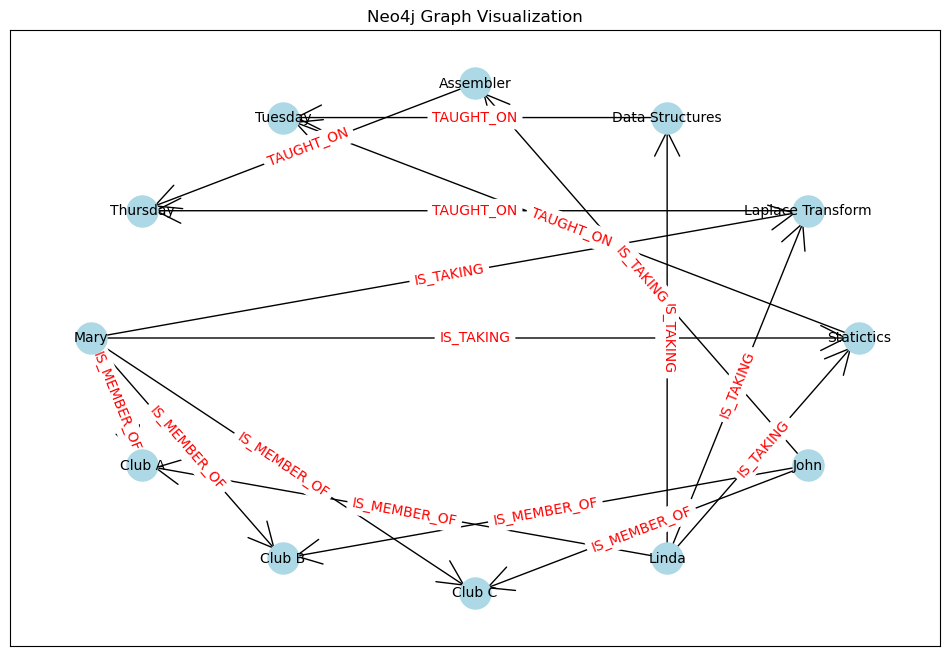

In [48]:
visualize_graph()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

# *************************************************************************** WORKSPACE ***************************************************************************

## Set A: (un)Fairness in ML Graph

In [72]:
my_neo4j_wipe_out_database()

query = """
CREATE
  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0)
"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Data Generation,[PROCESS]
3,Dataset,[ML_Workflow]
4,Deployment Bias,[BIAS]
5,Evaluation,[PROCESS]
6,Evaluation Bias,[BIAS]
7,Historical Bias,[BIAS]
8,Human & Model Interaction,[PROCESS]
9,Integrate into Systems,[PROCESS]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Data Generation,[PROCESS],FEEDS,World,[ML_Workflow]
4,Dataset,[ML_Workflow],FEEDS,"Preprocessing, Train/Test Split",[PROCESS]
5,Deployment Bias,[BIAS],BIASES,Human & Model Interaction,[PROCESS]
6,Deployment Bias,[BIAS],BIASES,Integrate into Systems,[PROCESS]
7,Deployment Bias,[BIAS],BIASES,Model Output,[ML_Workflow]
8,Deployment Bias,[BIAS],BIASES,Post-Process,[PROCESS]
9,Deployment Bias,[BIAS],BIASES,Run Model,[PROCESS]


-------------------------
  Density: 0.1
-------------------------


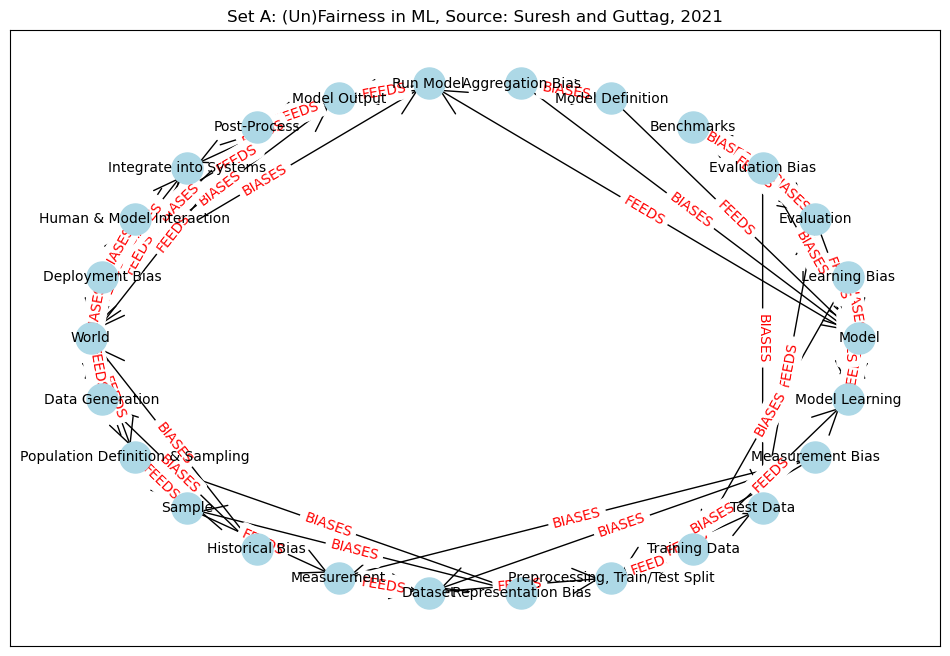

In [73]:
my_neo4j_nodes_relationships()
visualize_graph('Set A: (Un)Fairness in ML, Source: Suresh and Guttag, 2021')

![Set A: Unfairness in ML Graph](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Set_A.svg)

## Set C: Hypothetical Company Relationships Graph

Define the nodes, then define the relationships

In [77]:
my_neo4j_wipe_out_database()

query = """
CREATE
  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  (c0)-[:IS_PARENT_OF {since: 1984}]->(c00),
  (c00)-[:IS_PARENT_OF]->(c1),
  (c1)-[:IS_PARENT_OF]->(c2),
  (c1)-[:IS_PARENT_OF]->(c3),
  (c1)-[:IS_PARENT_OF]->(c4),
  (c1)-[:IS_PARENT_OF]->(c5),
  (c1)-[:IS_PARENT_OF]->(c6),
  (c1)-[:IS_PARENT_OF]->(c7),
  (c1)-[:IS_PARENT_OF]->(c8),
  (c1)-[:IS_PARENT_OF]->(c9),
  (c1)-[:IS_PARENT_OF]->(c10),
  (c1)-[:IS_PARENT_OF]->(c11),
  (c1)-[:IS_PARENT_OF]->(c12),
  (c1)-[:IS_PARENT_OF]->(c13),
  (c1)-[:IS_PARENT_OF]->(c14),
  (c1)-[:IS_PARENT_OF]->(c15),
  (c1)-[:IS_PARENT_OF]->(c16),
  (c1)-[:IS_PARENT_OF]->(c17),
  (c1)-[:IS_PARENT_OF]->(c18),
  (c1)-[:IS_PARENT_OF]->(c19),
  (c1)-[:IS_PARENT_OF]->(c20),
  (c1)-[:IS_PARENT_OF]->(c21)

"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Biotechnology,[Company]
1,Business Services,[Company]
2,Consumer Goods and Services,[Company]
3,Education,[Company]
4,Energy,[Company]
5,Financial Markets,[Company]
6,Financial Services,[Company]
7,Government,[Company]
8,Healthcare,[Company]
9,Information Technology,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,"OpenAI Global, LLC.",[Company],IS_PARENT_OF,OpenAI Web Services,[Company]
1,OpenAI Web Services,[Company],IS_PARENT_OF,Biotechnology,[Company]
2,OpenAI Web Services,[Company],IS_PARENT_OF,Business Services,[Company]
3,OpenAI Web Services,[Company],IS_PARENT_OF,Consumer Goods and Services,[Company]
4,OpenAI Web Services,[Company],IS_PARENT_OF,Education,[Company]
5,OpenAI Web Services,[Company],IS_PARENT_OF,Energy,[Company]
6,OpenAI Web Services,[Company],IS_PARENT_OF,Financial Markets,[Company]
7,OpenAI Web Services,[Company],IS_PARENT_OF,Financial Services,[Company]
8,OpenAI Web Services,[Company],IS_PARENT_OF,Government,[Company]
9,OpenAI Web Services,[Company],IS_PARENT_OF,Healthcare,[Company]


-------------------------
  Density: 0.1
-------------------------


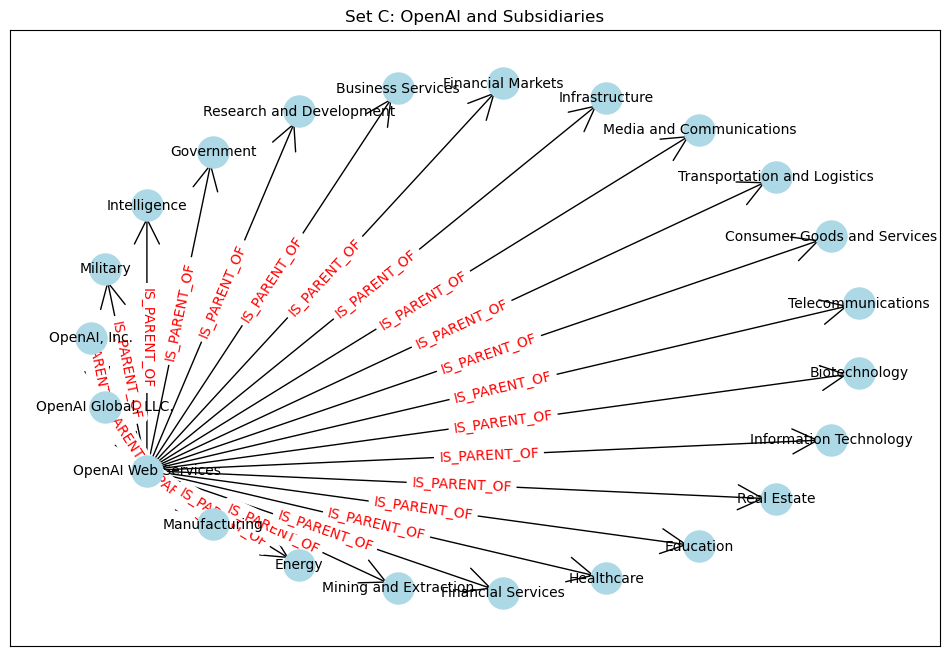

In [78]:
my_neo4j_nodes_relationships()
visualize_graph('Set C: OpenAI and Subsidiaries')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Set_C.svg)

## Set A & C: ML Workflow & Hypothetical Company (Relational Model)

Notation Guide: 
- 1 digit:  ML_Workflow or Company Node
- 2 digits: PROCESS
- 3 digits: bias

In [79]:
my_neo4j_wipe_out_database()

query = """
CREATE
  
  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.
  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (c0)-[:IS_PARENT_OF {since: 1984}]->(c00),
  (c00)-[:IS_PARENT_OF]->(c1),
  (c1)-[:IS_PARENT_OF]->(c2),
  (c1)-[:IS_PARENT_OF]->(c3),
  (c1)-[:IS_PARENT_OF]->(c4),
  (c1)-[:IS_PARENT_OF]->(c5),
  (c1)-[:IS_PARENT_OF]->(c6),
  (c1)-[:IS_PARENT_OF]->(c7),
  (c1)-[:IS_PARENT_OF]->(c8),
  (c1)-[:IS_PARENT_OF]->(c9),
  (c1)-[:IS_PARENT_OF]->(c10),
  (c1)-[:IS_PARENT_OF]->(c11),
  (c1)-[:IS_PARENT_OF]->(c12),
  (c1)-[:IS_PARENT_OF]->(c13),
  (c1)-[:IS_PARENT_OF]->(c14),
  (c1)-[:IS_PARENT_OF]->(c15),
  (c1)-[:IS_PARENT_OF]->(c16),
  (c1)-[:IS_PARENT_OF]->(c17),
  (c1)-[:IS_PARENT_OF]->(c18),
  (c1)-[:IS_PARENT_OF]->(c19),
  (c1)-[:IS_PARENT_OF]->(c20),
  (c1)-[:IS_PARENT_OF]->(c21),

  //  P1, deprioritized: World connects to pop defn and sampling, to measurement, to preprocess train-test split, to benchmarks
  //  (a0)-[:FEEDS]->(a01),
  //  (a01)-[:FEEDS]->(a10),
  //

  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
//  (a01)-[:FEEDS]->(a5),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0),
  (c00)-[:FEEDS]->(a70)
"""

session.run(query)


-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Biotechnology,[Company]
3,Business Services,[Company]
4,Consumer Goods and Services,[Company]
5,Data Generation,[PROCESS]
6,Dataset,[ML_Workflow]
7,Deployment Bias,[BIAS]
8,Education,[Company]
9,Energy,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Data Generation,[PROCESS],FEEDS,World,[ML_Workflow]
4,Dataset,[ML_Workflow],FEEDS,"Preprocessing, Train/Test Split",[PROCESS]
...,...,...,...,...,...
64,Sample,[ML_Workflow],FEEDS,Measurement,[PROCESS]
65,Test Data,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
66,Training Data,[ML_Workflow],FEEDS,Model Learning,[PROCESS]
67,World,[ML_Workflow],FEEDS,Data Generation,[PROCESS]


-------------------------
  Density: 0.1
-------------------------


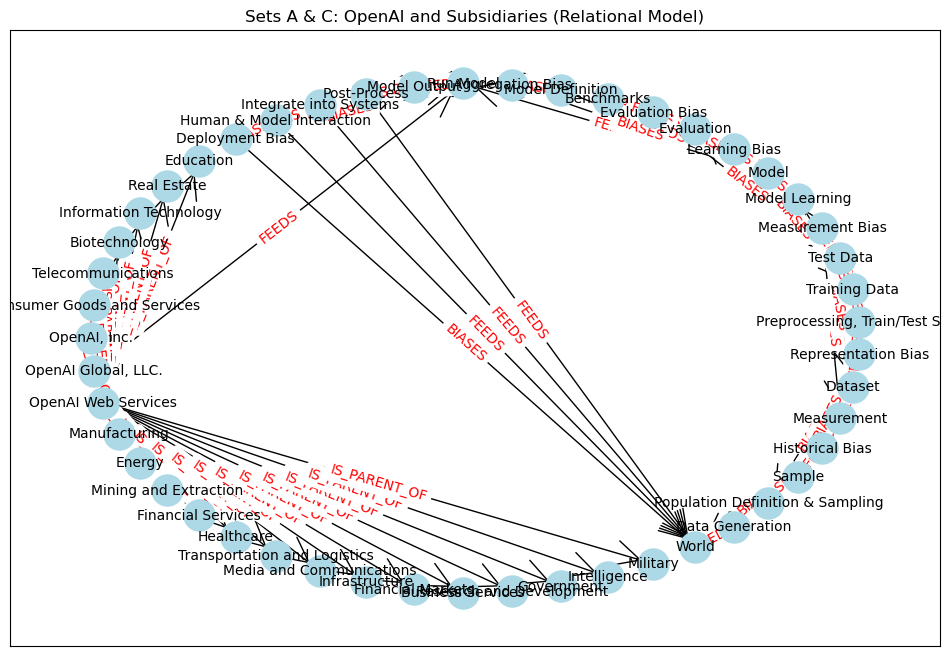

In [81]:
my_neo4j_nodes_relationships()
visualize_graph('Sets A & C: OpenAI and Subsidiaries (Relational Model)')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Relational_Model.svg)

## Set A & C: ML Workflow & Hypothetical Company (Operational Model)

Notation Guide: 
- 1 digit:  ML_Workflow or Company Node
- 2 digits: PROCESS
- 3 digits: bias


In [70]:
my_neo4j_wipe_out_database()

query = """
CREATE
  
  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.

  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (c0)-[:IS_PARENT_OF {since: 1984}]->(c00),
  (c00)-[:IS_PARENT_OF]->(c1),
  (c1)-[:IS_PARENT_OF]->(c2),
  (c1)-[:IS_PARENT_OF]->(c3),
  (c1)-[:IS_PARENT_OF]->(c4),
  (c1)-[:IS_PARENT_OF]->(c5),
  (c1)-[:IS_PARENT_OF]->(c6),
  (c1)-[:IS_PARENT_OF]->(c7),
  (c1)-[:IS_PARENT_OF]->(c8),
  (c1)-[:IS_PARENT_OF]->(c9),
  (c1)-[:IS_PARENT_OF]->(c10),
  (c1)-[:IS_PARENT_OF]->(c11),
  (c1)-[:IS_PARENT_OF]->(c12),
  (c1)-[:IS_PARENT_OF]->(c13),
  (c1)-[:IS_PARENT_OF]->(c14),
  (c1)-[:IS_PARENT_OF]->(c15),
  (c1)-[:IS_PARENT_OF]->(c16),
  (c1)-[:IS_PARENT_OF]->(c17),
  (c1)-[:IS_PARENT_OF]->(c18),
  (c1)-[:IS_PARENT_OF]->(c19),
  (c1)-[:IS_PARENT_OF]->(c20),
  (c1)-[:IS_PARENT_OF]->(c21),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.
  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
//  (a01)-[:FEEDS]->(a5),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0),

  //
  (c00)-[:FEEDS]->(a70), 
  // New relationships between c1-c21 and a0: World
  (c1)-[:FEEDS]->(a0),
  (c2)-[:FEEDS]->(a0),
  (c3)-[:FEEDS]->(a0),
  (c4)-[:FEEDS]->(a0),
  (c5)-[:FEEDS]->(a0),
  (c6)-[:FEEDS]->(a0),
  (c7)-[:FEEDS]->(a0),
  (c8)-[:FEEDS]->(a0),
  (c9)-[:FEEDS]->(a0),
  (c10)-[:FEEDS]->(a0),
  (c11)-[:FEEDS]->(a0),
  (c12)-[:FEEDS]->(a0),
  (c13)-[:FEEDS]->(a0),
  (c14)-[:FEEDS]->(a0),
  (c15)-[:FEEDS]->(a0),
  (c16)-[:FEEDS]->(a0),
  (c17)-[:FEEDS]->(a0),
  (c18)-[:FEEDS]->(a0),
  (c19)-[:FEEDS]->(a0),
  (c20)-[:FEEDS]->(a0),
  (c21)-[:FEEDS]->(a0)

"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Biotechnology,[Company]
3,Business Services,[Company]
4,Consumer Goods and Services,[Company]
5,Data Generation,[PROCESS]
6,Dataset,[ML_Workflow]
7,Deployment Bias,[BIAS]
8,Education,[Company]
9,Energy,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Data Generation,[PROCESS],FEEDS,World,[ML_Workflow]
4,Dataset,[ML_Workflow],FEEDS,"Preprocessing, Train/Test Split",[PROCESS]
...,...,...,...,...,...
64,Sample,[ML_Workflow],FEEDS,Measurement,[PROCESS]
65,Test Data,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
66,Training Data,[ML_Workflow],FEEDS,Model Learning,[PROCESS]
67,World,[ML_Workflow],FEEDS,Data Generation,[PROCESS]


-------------------------
  Density: 0.1
-------------------------


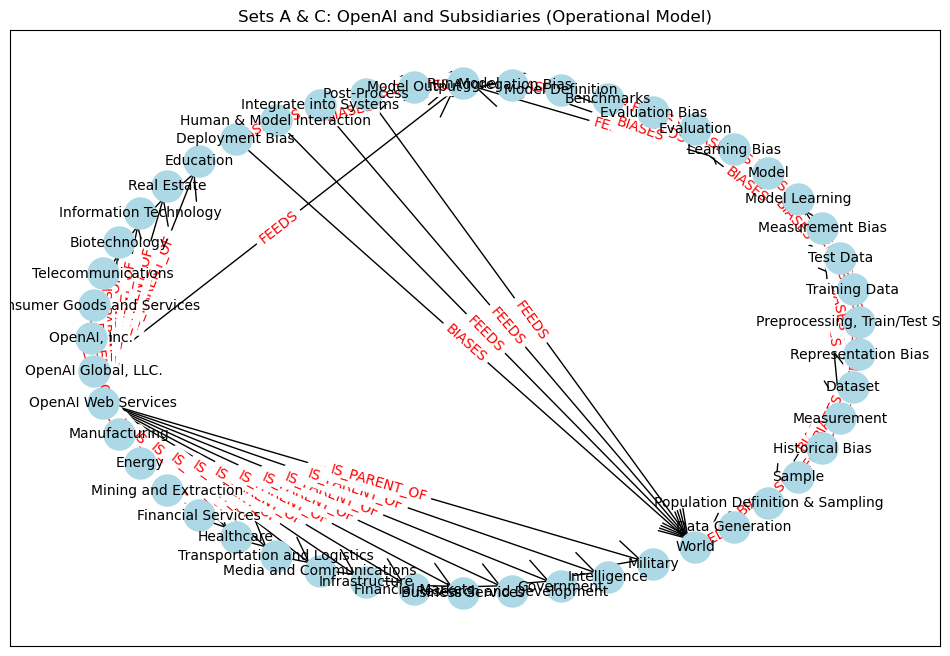

In [82]:
my_neo4j_nodes_relationships()
visualize_graph('Sets A & C: OpenAI and Subsidiaries (Operational Model)')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Operational_Model.svg)

## Algorithm 1: Degree Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Degree Centrality Results
--------------------------------
                                Node  Degree Centrality
0                OpenAI Web Services               20.0
1                    Deployment Bias                6.0
2                    Evaluation Bias                4.0
3                       Model Output                3.0
4                   Measurement Bias                3.0
5                      Learning Bias                3.0
6                OpenAI Global, LLC.                2.0
7    Preprocessing, Train/Test Split                2.0
8                   Aggregation Bias                2.0
9                              Model                2.0
10                             World                2.0
11                   Historical Bias                2.0
12               Representation Bias                2.0
13                      OpenAI, Inc.                1.0
14                        Evaluation                1.0
15      

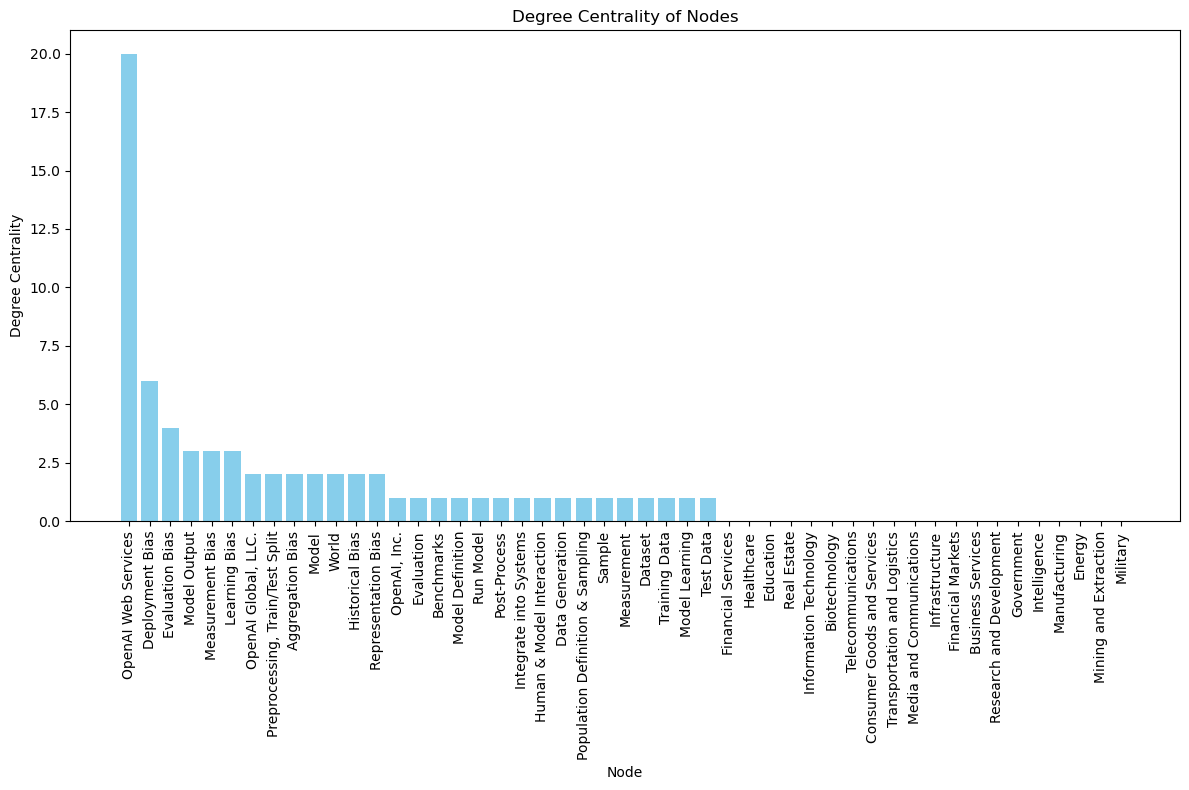

In [83]:
def my_neo4j_degree_centrality():
    """
    Compute the degree centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")

    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the degree centrality algorithm
    query = """
    CALL gds.degree.stream('ds_graph')
    YIELD nodeId, score AS centrality
    RETURN gds.util.asNode(nodeId).name AS node, centrality
    ORDER BY centrality DESC
    """

    result = session.run(query)

    data = []
    for r in result:
        data.append({"Node": r['node'], "Degree Centrality": r['centrality']})
    df = pd.DataFrame(data)
    
    print("\n--------------------------------")
    print("   Degree Centrality Results")
    print("--------------------------------")
    print(df)
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Degree Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Degree Centrality')
    plt.title('Degree Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_degree_centrality()

Degree Centrality measures the number of direct connections a graph node has and is a proxy for how important or influential a node might be in the network. 

- OpenAI Web Services (OWS) has the highest number of direct connections, by far
- Deployment and Evaluation Biases are next, followed by Model Output, Measurement and Learning Biases—becauase they play important roles in the network
- The non-profit parent company, Open AI, Inc., who is technically the owner and operator of OpenAI Global, LLC, appears to have less of an important role in the graph. OpenAI Global, LLC is actually the next most important node after Learning Bias, ranking 7th. 
- Interestingly, the World ranks 11th

## Algorithm 2: Betweenness Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Betweenness Centrality Results
--------------------------------
                                Node  Betweenness Centrality
0                          Run Model              239.000000
1                              World              232.000000
2                       Model Output              229.000000
3                              Model              222.000000
4                             Sample              201.000000
5   Population Definition & Sampling              196.000000
6                        Measurement              191.000000
7    Preprocessing, Train/Test Split              185.000000
8                            Dataset              181.000000
9                         Evaluation               84.500000
10                         Test Data               77.500000
11                     Training Data               71.500000
12                    Model Learning               68.500000
13                      Post-Process         

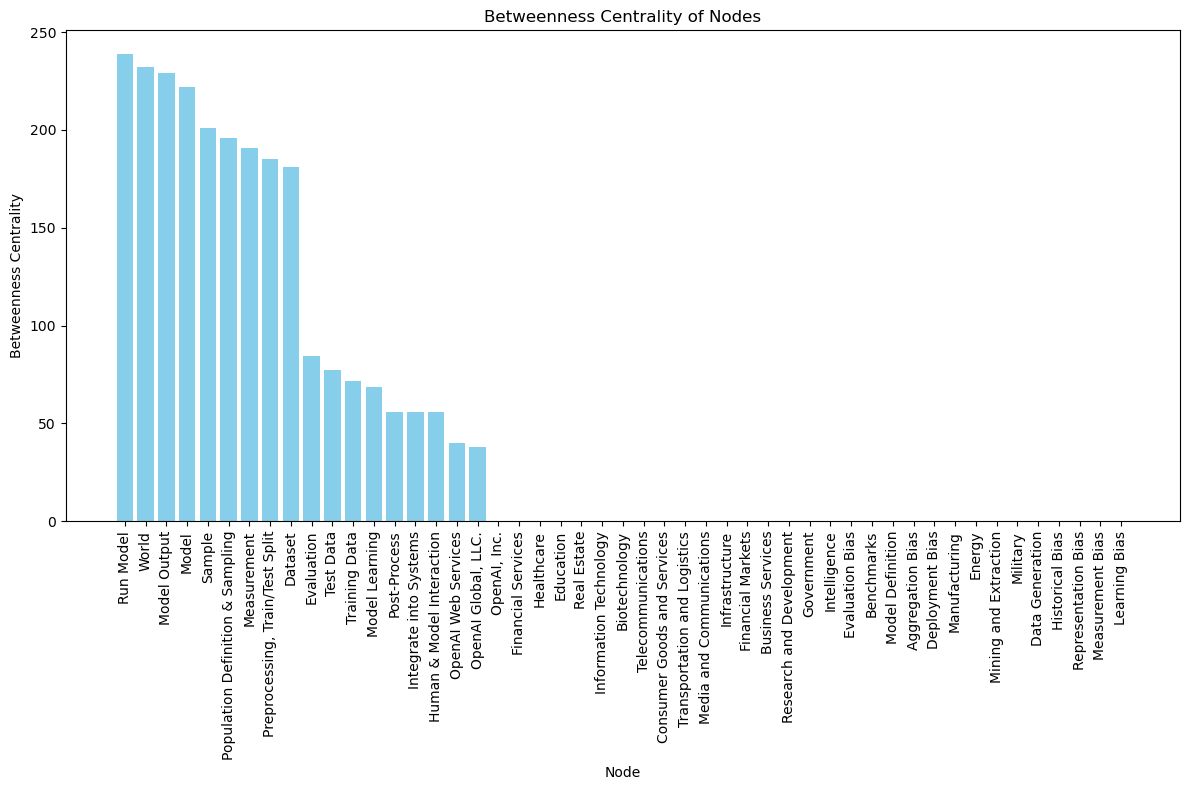

In [84]:
def my_neo4j_betweenness_centrality():
    """
    Compute the betweenness centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the betweenness centrality algorithm
    query = """
    CALL gds.betweenness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS node, score AS betweenness
    ORDER BY betweenness DESC
    """

    result = session.run(query)
    
    # Store the results in a df
    data = []
    for r in result:
        data.append({"Node": r['node'], "Betweenness Centrality": r['betweenness']})
    
    df = pd.DataFrame(data)
    
    print("\n--------------------------------")
    print("   Betweenness Centrality Results")
    print("--------------------------------")
    print(df)
    
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Betweenness Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Betweenness Centrality')
    plt.title('Betweenness Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_betweenness_centrality()

Betweenness Centrality measures the number of times a node acts as a bridge along the shortest path between two other nodes. It serves as a proxy for how important a node is in controlling the flow of information or energy within the graph network

- Running Models, the World's Data Generation feedback loop and it's relationship to Model Output all serve as an essential center to understand the potential relationship between the proliferation of Machine Learning Models in the World. 
- The next several results all gradually descend in importance, indicating that the Processes, and their Inputs and Outputs, are the most essential factors in how Bias proliferates through the World.

## Algorithm 3: Louvain Modularity

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Louvain Modularity Results
--------------------------------
                                Node  Community ID
0                 Financial Services            11
1                         Healthcare            11
2                          Education            11
3                        Real Estate            11
4             Information Technology            11
5                      Biotechnology            11
6                 Telecommunications            11
7        Consumer Goods and Services            11
8       Transportation and Logistics            11
9           Media and Communications            11
10               OpenAI Web Services            11
11                    Infrastructure            12
12                 Financial Markets            13
13                 Business Services            14
14          Research and Development            15
15                        Government            16
16                      Intelligence

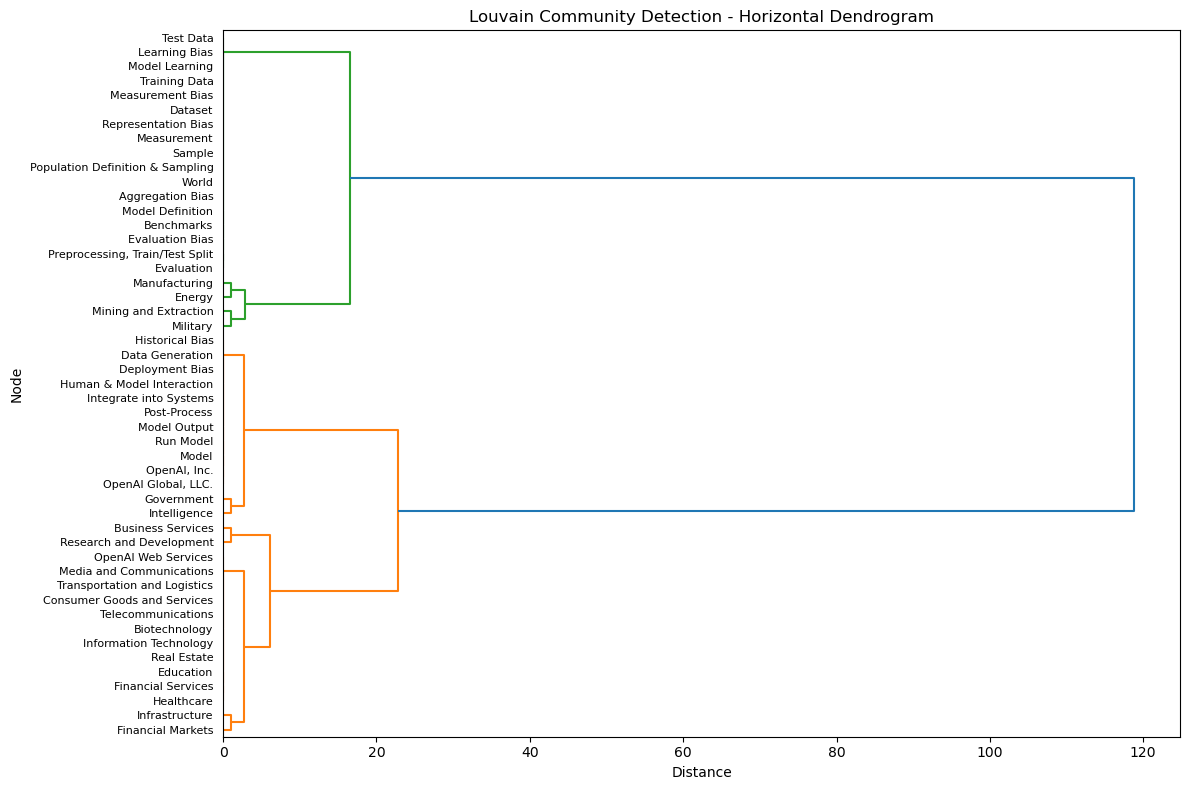

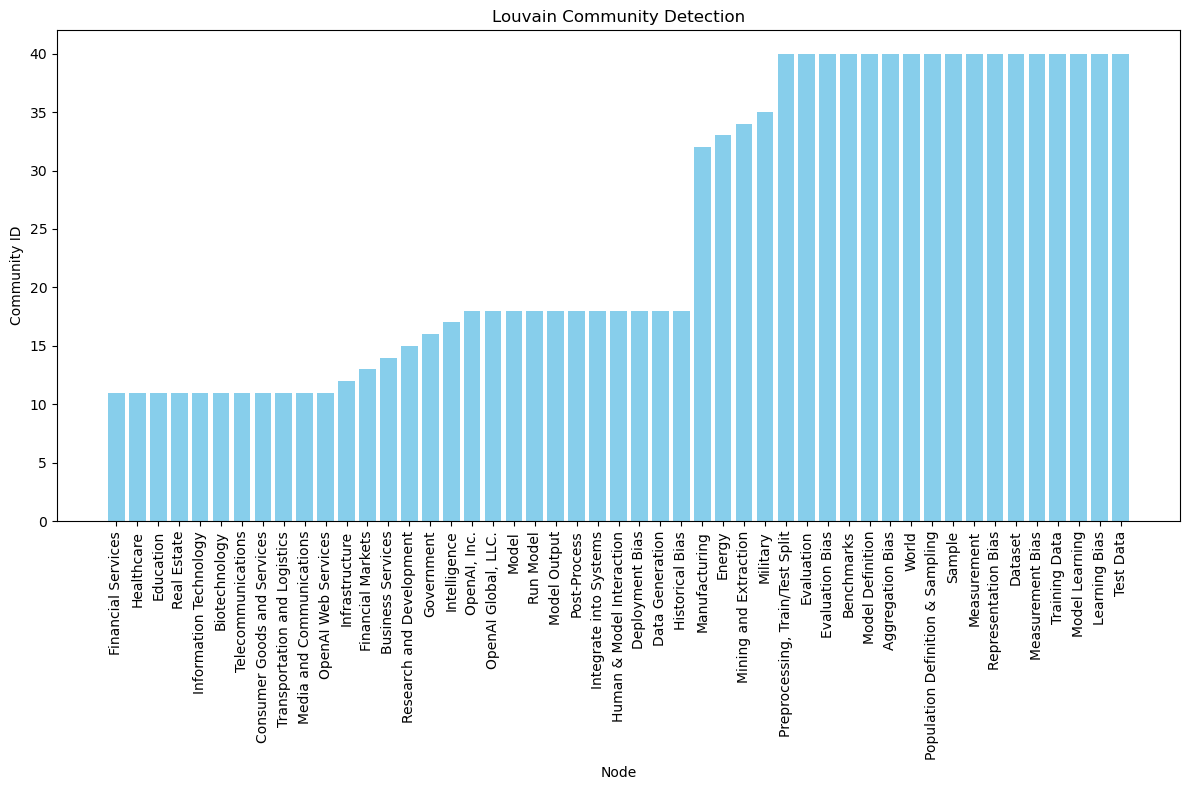

In [87]:
def my_neo4j_louvain_modularity():
    """
    Compute the Louvain modularity for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the Louvain modularity algorithm
    query = """
    CALL gds.louvain.stream('ds_graph')
    YIELD nodeId, communityId
    RETURN gds.util.asNode(nodeId).name AS node, communityId
    ORDER BY communityId
    """

    result = session.run(query)
    
    # Store the results in a DataFrame
    data = []
    for r in result:
        data.append({"Node": r['node'], "Community ID": r['communityId']})
    
    df = pd.DataFrame(data)
    
    # Print the results
    print("\n--------------------------------")
    print("   Louvain Modularity Results")
    print("--------------------------------")
    print(df)


    # horizontal dendrogram
    plt.figure(figsize=(12, 8))
    linked = linkage(df['Community ID'].values.reshape(-1, 1), method='ward')
    dendrogram(linked, labels=df['Node'].values, orientation='right', distance_sort='descending', show_leaf_counts=True)

    plt.xlabel('Distance')
    plt.ylabel('Node')
    plt.title('Louvain Community Detection - Horizontal Dendrogram')
    plt.tight_layout()
    plt.show()

    # bar plot
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Community ID'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Community ID')
    plt.title('Louvain Community Detection')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_louvain_modularity()

Louvain Modularity is a community detection algorithm that identifies groups of nodes that are more densely connected with each other than with the rest of the network. When the modularity score increases, it measures how strong a subdivision of the network is. 

- ID 11: Financial Services, Healthcare, Education, Real Estate, Information Technology, Biotechnology, Telecommunications, Consumer Goods and Services, Transportation and Logistics, Media and Communications, OpenAI Web Services. This result seems to reflect the Operational Model of the 'Public Benefit Corporation'. 
- ID 18: OpenAI, Inc., OpenAI Global, LLC., Model, Run Model, Model Output, Post-Process, Integrate into Systems, Human & Model Interaction, Deployment Bias, Data Generation, Historical Bias. This result seems to reflect a chain of ownership around the Bias process

## Unused: Harmonic Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.alpha.closeness.harmonic.stream' has been replaced by 'gds.closeness.harmonic.stream')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.alpha.closeness.harmonic.stream('ds_graph')\n    YIELD nodeId, centrality\n    RETURN gds.util.asNode(nodeId).name


--------------------------------
   Harmonic Centrality Results
--------------------------------
                                Node  Harmonic Centrality
0                              Model             0.211011
1                              World             0.208732
2                          Run Model             0.196074
3                     Model Learning             0.185310
4   Population Definition & Sampling             0.169098
5                       Model Output             0.159610
6                    Data Generation             0.151737
7                             Sample             0.147091
8                        Measurement             0.143437
9                       Post-Process             0.142279
10            Integrate into Systems             0.142279
11         Human & Model Interaction             0.142279
12                        Evaluation             0.140195
13                           Dataset             0.132185
14                     Training 

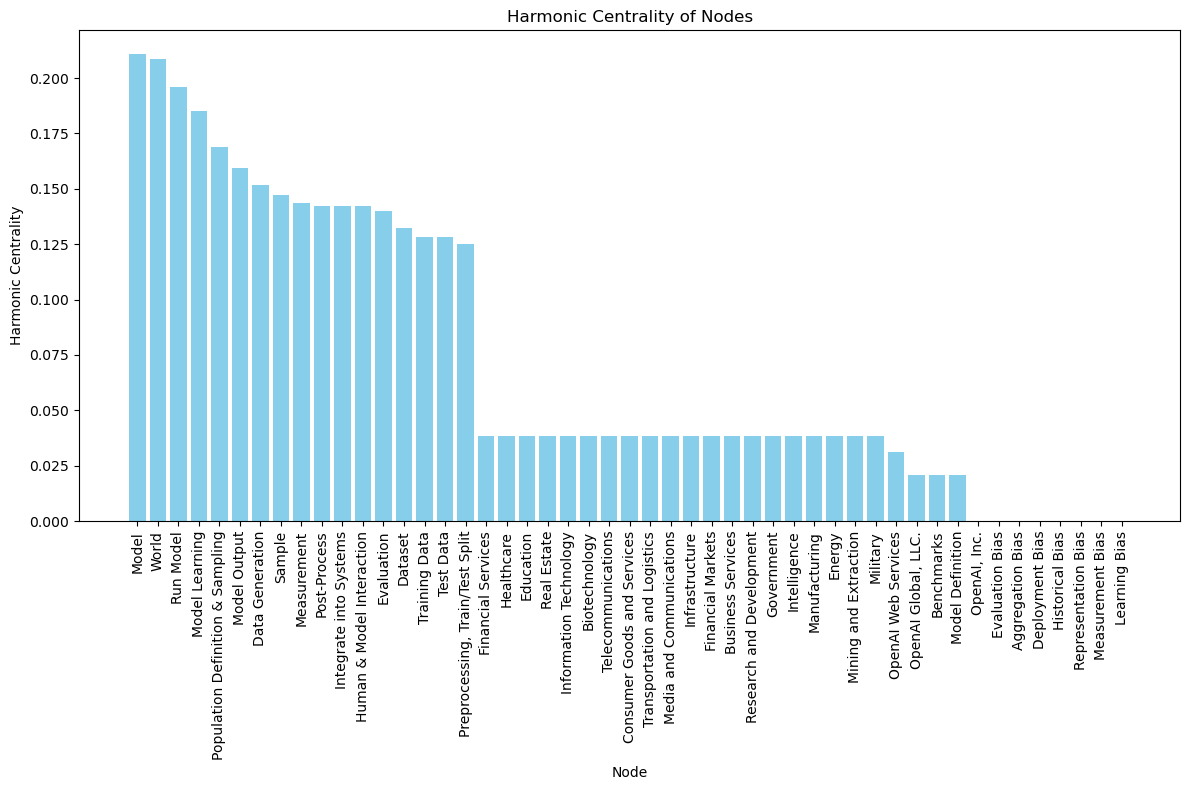

In [88]:
def my_neo4j_harmonic_centrality():
    """
    Compute the harmonic centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the harmonic centrality algorithm
    query = """
    CALL gds.alpha.closeness.harmonic.stream('ds_graph')
    YIELD nodeId, centrality
    RETURN gds.util.asNode(nodeId).name AS node, centrality
    ORDER BY centrality DESC
    """

    result = session.run(query)
    data = []
    for r in result:
        data.append({"Node": r['node'], "Harmonic Centrality": r['centrality']})

    df = pd.DataFrame(data)

    print("\n--------------------------------")
    print("   Harmonic Centrality Results")
    print("--------------------------------")
    print(df)
    
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Harmonic Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Harmonic Centrality')
    plt.title('Harmonic Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_harmonic_centrality()